## Урок 4. Image Segmentation

Задание 1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).


In [1]:
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples

In [2]:
# !unzip -q /content/makeup-lips-segmentation-28k-samples.zip -d /content/data

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [5]:
path = "data/set-lipstick-original/"
image_path = "data/set-lipstick-original/720p/"
mask_path = "data/set-lipstick-original/mask/"

In [6]:
lips_df = pd.read_csv(path + "list.csv")
lips_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [7]:
lips_df.describe()

,width,height,xmin,ymin,xmax,ymax
count,28594.0,28594.000000,28594.000000,28594.000000,28594.00000,28594.000000
mean,1280.0,718.663881,598.519445,301.300273,704.45632,362.676016
std,0.0,7.638207,84.979569,84.473834,88.29236,96.020078
min,1280.0,675.000000,170.000000,22.000000,280.00000,98.000000
25%,1280.0,720.000000,578.000000,242.000000,672.00000,295.000000
50%,1280.0,720.000000,601.000000,294.000000,691.00000,356.000000
75%,1280.0,720.000000,630.000000,356.000000,724.00000,419.000000
max,1280.0,720.000000,1036.000000,577.000000,1082.00000,650.000000


In [8]:
lips_df.nunique().sort_values() # Количество уникальных значений по столбцам

width           1
class           1
height          2
ymin          481
ymax          522
xmax          691
xmin          721
filename    28594
mask        28594
dtype: int64

In [9]:
np.unique(plt.imread(mask_path + 'mask00000004.png')[:,:,0]*255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        78.,  79.,  83.,  84.,  85.,  86.,  87.,  88.,  91.,  92.,  94.,
        95.,  96.,  99., 100., 103.], dtype=float32)

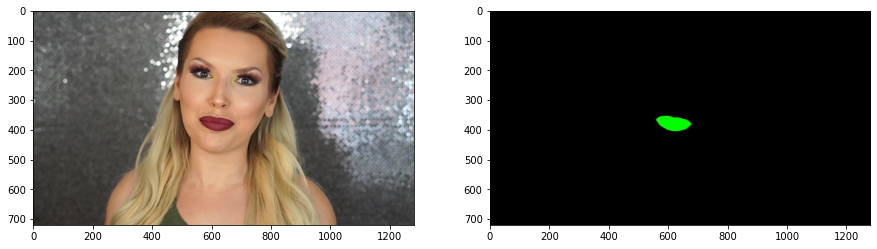

In [10]:
f, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(plt.imread(image_path + "image00000004.jpg")) 
ax[1].imshow(plt.imread(mask_path + "mask00000004.png"))
plt.show()

In [11]:
df = lips_df[['filename', 'mask']]
df.isna().any()

filename    False
mask        False
dtype: bool

In [12]:
df['filename'] = image_path + df['filename']
df['mask'] = mask_path + df['mask']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
df.head()

,filename,mask
0,data/set-lipstick-original/720p/image00000001.jpg,data/set-lipstick-original/mask/mask00000001.png
1,data/set-lipstick-original/720p/image00000002.jpg,data/set-lipstick-original/mask/mask00000002.png
2,data/set-lipstick-original/720p/image00000003.jpg,data/set-lipstick-original/mask/mask00000003.png
3,data/set-lipstick-original/720p/image00000004.jpg,data/set-lipstick-original/mask/mask00000004.png
4,data/set-lipstick-original/720p/image00000005.jpg,data/set-lipstick-original/mask/mask00000005.png


In [14]:
# в датасете есть наименования файлов, отсутствующие физически в папках.
# удалим их
for idx in df.index:
    if not os.path.isfile(df["filename"][idx]) or not os.path.isfile(df["mask"][idx]):
        df.drop(index=idx, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
df.nunique().sort_values() # Количество уникальных значений по столбцам

filename    28540
mask        28540
dtype: int64

In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

Создадим класс для кастомного датасета:

In [18]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index])).astype('float')
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем (13)2 канала масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(lab.max(axis=2, keepdims=True)).permute(2,0,1)

        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')

        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

Затем разделим наш датасет на тренировочную и тестовую выборки. И обернем их в наш кастомный класс.

In [19]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

И теперь уже обернем то, что получилось в известные нам в pytorch даталоадеры:

In [20]:
train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Задание 2.	И затем обучить Модель на выбор из segmentation_models_pytorch


## Обучение

In [21]:
# !pip install segmentation_models_pytorch

In [22]:
import segmentation_models_pytorch as smp
import time
from torch.autograd import Variable
from sklearn.metrics import jaccard_similarity_score as jsc


In [23]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score

Определим скорость обучения и количество эпох:

In [24]:
learning_rate = 0.001
epochs = 5

In [25]:
model_lips = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
optimizer = torch.optim.Adam(model_lips.parameters(), lr=learning_rate)
loss_lips = smp.utils.losses.DiceLoss()

In [26]:
# создание модели
# model_lips = smp.Unet()
# model_lips = smp.Unet('resnet34', classes=1, activation='softmax').to(device)

# optimizer = torch.optim.Adam(model_lips.parameters(), lr=learning_rate)
# criterion = SoftDiceLoss()

epoch_losses = []

for epoch in range(2):  # loop over the dataset multiple times
    epoch_loss = []
    time1 = time.time()
    sum_loss = 0.0
    count_batch = 0

    for i, data in enumerate(train_data_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print("in", inputs[0], "lab", labels[0])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_lips(inputs[0])
        loss = loss_lips(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        sum_loss += loss.item()
        epoch_loss.append(loss.item())
        count_batch += 1
        if count_batch % 1000 == 999:    # print every 1000 mini-batches
            print(f'Epoch: {epoch+1}, batchcount: {count_batch+1}, avg. loss for last 1000 images: {sum_loss/1000}')

    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss), f' Spend time = {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch 1, loss:  0.9890491005721366  Spend time = 2335.503831386566 sec
Epoch 2, loss:  0.9901955366893939  Spend time = 1993.5203919410706 sec


In [27]:
savePATH = './selfLastModelSoft.pth'

In [28]:
torch.save(model_lips.state_dict(), savePATH)

In [29]:
model_lips.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

In [30]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


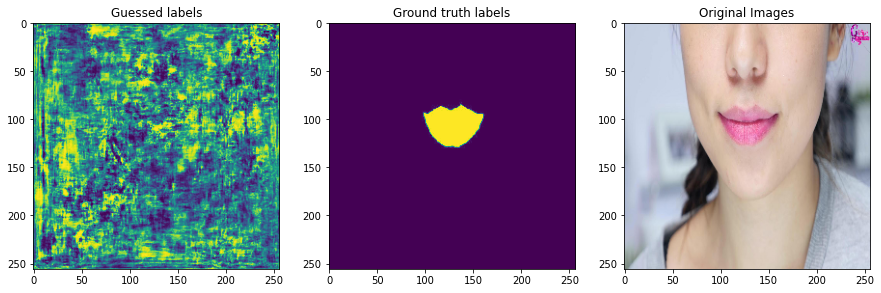

<Figure size 432x288 with 0 Axes>

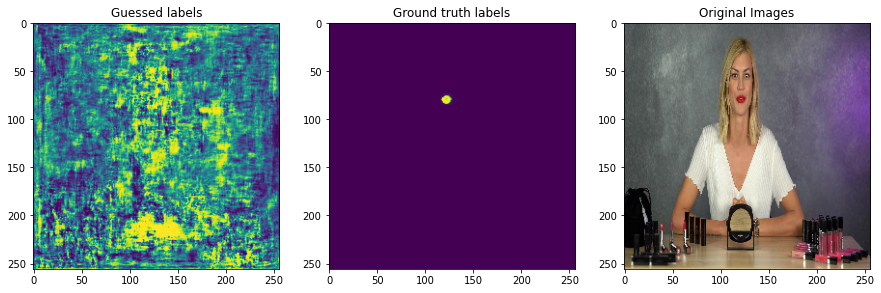

<Figure size 432x288 with 0 Axes>

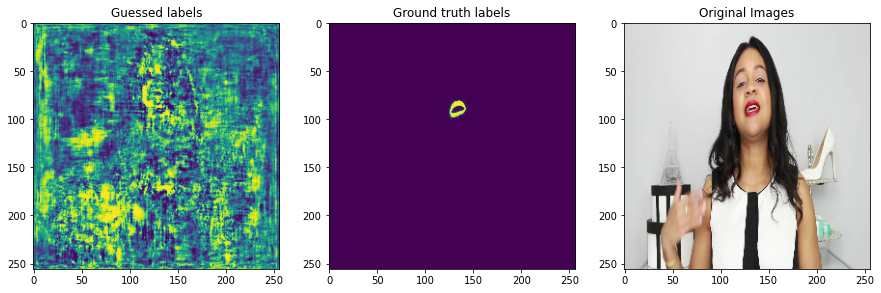

<Figure size 432x288 with 0 Axes>

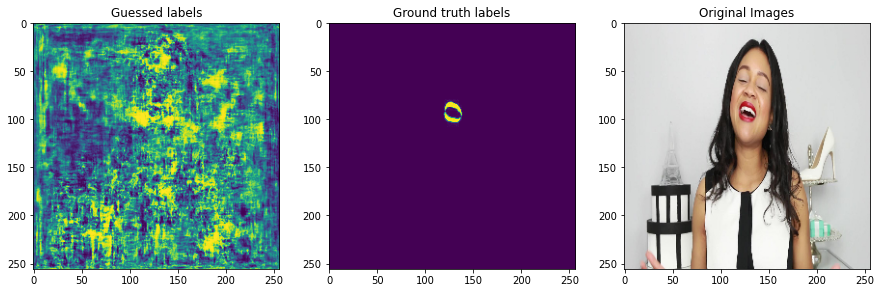

<Figure size 432x288 with 0 Axes>

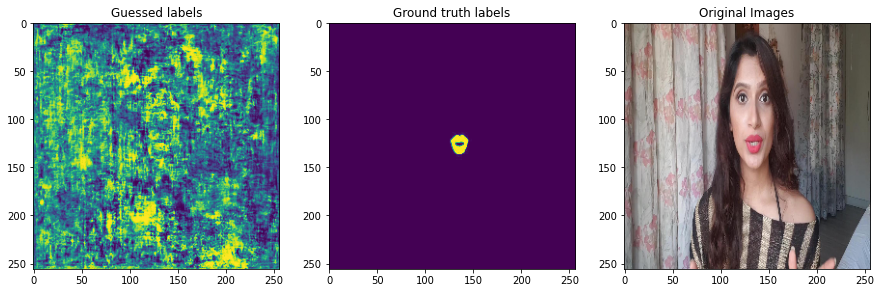

<Figure size 432x288 with 0 Axes>

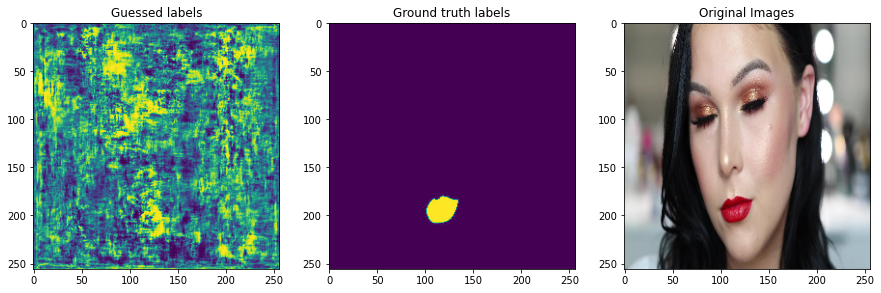

<Figure size 432x288 with 0 Axes>

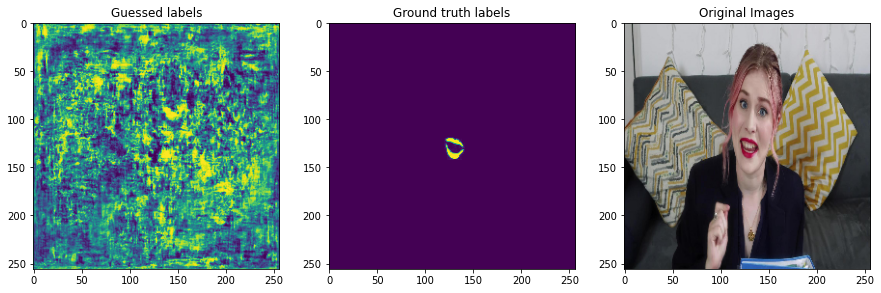

<Figure size 432x288 with 0 Axes>

In [31]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = model_lips(images[0].cuda())
    f, axarr = plt.subplots(1,3, figsize=(15, 5))

    axarr[0].imshow(outputs.detach().cpu().numpy()[0,0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    original = get_orig(images[0][0,:,:,:])
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

Задание 3.	*(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.
